# <span style="color:#0b486b">  FIT5215: Deep Learning (2023)</span>
***
*CE/Lecturer:* Dr **Trung Le** | trunglm@monash.edu <br/>
*Head Tutor:* Mr **Tuan Nguyen** | tuan.nguyen@monash.edu <br/>
<br/>
Department of Data Science and AI, Faculty of Information Technology, Monash University, Australia
***

# <span style="color:#0b486b">  Student Information</span>
Surname: **Yee**  <br/>
Firstname: **Darren Jer Shien**    <br/>
Student ID: **31237223**    <br/>
Email: **dyee0005@student.monash.edu**    <br/>
Your tutorial time: **Monday 10AM**    <br/>
***

## <span style="color:#0b486b">Assignment 02: Neural Embedding and Sequence Modelling</span>
### Due: <span style="color:red">11:59pm 22 October 2023</span>  (Sunday)

#### <span style="color:red">Important note:</span> This is an **individual** assignment. It contributes **20%** to you final mark. Read the assignment instruction carefully.

## <span style="color:#0b486b">Instructions</span>

This notebook has been prepared for your to complete Assignment 2. The theme of this assignment is about practical machine learning knowledge and skills in deep neural networks, word embedding and text analytics. Some sections have been partially completed to help you get
started. **The total marks for this notebook is 100**.

* Before you start, read the entire notebook carefully once to understand what you need to do. <br><br>
* For each cell marked with **#YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL**, there will be places where you **must** supply your own codes when instructed. <br>

This assignment contains **four** parts:

* Part 1: Questions on downloading and preprocessing data **[5 points]**
* Part 2: Questions on using Word2Vect to transform texts to vectors **[20 points]**
* Part 3: Coding assessment on BERT and CLIP for a feature extraction **[15 points]**
* Part 4: Coding assessment on RNNs for sequence modeling and neural embedding **[60 points]**


**Hint**: This assignment was essentially designed based on the lectures and tutorials sessions covered from Weeks 6 to 10. You are strongly recommended to go through these contents thoroughly which might help you to complete this assignment.

## <span style="color:#0b486b">What to submit</span>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <span style="color:red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</span> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. 

***For example, if your student ID is <span style="color:red; font-weight:bold">12356</span>, then gather all of your assignment solution to folder, create a zip file named <span style="color:red; font-weight:bold">123456_assignment02_solution.zip</span> and submit this file.***

Within this zip folder, you **must** submit the following files:
1.	**Assignment02_solution.ipynb**:  this is your Python notebook solution source file.
1.	**Assignment02_output.html**: this is the output of your Python notebook solution *exported* in html format.
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [83]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 1: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 5 points]<span></div>

The dataset we use for this assignment is a question classification dataset for which the train set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).


Preprocessing data is an inital and important step in any machine learning or deep learning projects. The following *DataManager* class helps you to download data and preprocess data for the later questions of this assignment. 

In [84]:
import os
import zipfile
import collections
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

class DataManager:
    def __init__(self, verbose=True, maxlen= 50, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = maxlen
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)
        
    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose= True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))
    
    def read_data(self, dir_name, file_names):
        self.str_questions= list(); self.str_labels= list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str= row.split(":")
                    label, question= row_str[0], row_str[1]
                    question= question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len= len(self.str_questions[-1])
         
        # turns labels into numbers
        le= preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes= le.classes_
        self.num_classes= len(self.str_classes)
        if self.verbose:
            print("\nSample questions... \n")
            print(self.str_questions[0:5])
            print("Labels {}\n\n".format(self.str_classes))
    
    def manipulate_data(self):
        tokenizer = tf.keras.preprocessing.text.Tokenizer()
        tokenizer.fit_on_texts(self.str_questions)
        self.numeral_data = tokenizer.texts_to_sequences(self.str_questions)
        self.numeral_data = tf.keras.preprocessing.sequence.pad_sequences(self.numeral_data, padding='post', truncating= 'post', maxlen= self.maxlen)
        self.word2idx = tokenizer.word_index
        self.word2idx = {k:v for k,v in self.word2idx.items()}
        self.idx2word = {v:k for k,v in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
    
    def train_valid_split(self, train_ratio=0.9):
        idxs = np.random.permutation(np.arange(len(self.str_questions)))
        train_size = int(train_ratio*len(idxs)) +1
        self.train_str_questions, self.valid_str_questions = self.str_questions[0:train_size], self.str_questions[train_size:]
        self.train_numeral_data, self.valid_numeral_data = self.numeral_data[0:train_size], self.numeral_data[train_size:]
        self.train_numeral_labels, self.valid_numeral_labels = self.numeral_labels[0:train_size], self.numeral_labels[train_size:]
        self.tf_train_set = tf.data.Dataset.from_tensor_slices((self.train_numeral_data, self.train_numeral_labels))
        self.tf_valid_set = tf.data.Dataset.from_tensor_slices((self.valid_numeral_data, self.valid_numeral_labels))

In [85]:
print('Loading data...')
DataManager.maybe_download("Data", "train_1000.label", "http://cogcomp.org/Data/QA/QC/")
DataManager.maybe_download("Data", "TREC_10.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("Data/", ["train_1000.label", "TREC_10.label"])   # read data
# If you want to play around with a bigger dataset, you can try train_set.label

Loading data...
Downloaded successfully train_1000.label
Downloaded successfully TREC_10.label

Sample questions... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
Labels ['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']




In [86]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

#### <span style="color:red">**Question 1.1**</span> 
**What is the purpose of `self.train_str_questions` and `self.train_numeral_labels`? Write your code to print out the first five questions with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

**self.train_str_questions** represents the questions within the training set in the data, it is used to train the model

**self.train_numeral_labels** represents the labels assigned to each questions. It signifies which categories the specific training question belongs to and is used to train the model as well.




In [87]:
#Your code here
for i in range (5):
    print('question ',i,':',dm.train_str_questions[i],' label ',i,':',dm.train_numeral_labels[i],'\n')

question  0 : manner how did serfdom develop in and then leave russia ?  label  0 : 1 

question  1 : cremat what films featured the character popeye doyle ?  label  1 : 2 

question  2 : manner how can i find a list of celebrities ' real names ?  label  2 : 1 

question  3 : animal what fowl grabs the spotlight after the chinese year of the monkey ?  label  3 : 2 

question  4 : exp what is the full form of .com ?  label  4 : 0 



#### <span style="color:red">**Question 1.2**</span> 
**What is the purpose of `self.train_numeral_data`? Write your code to print out the first five questions in the numeric format with labels in the training set.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

The **self.train_numeral_data** is a vector that of size 100 that shows the numerical label each word belongs to according to the tokenizer preprocessing.



In [88]:
#Your code here
for i in range (5):
    print('numeral ',i,':',dm.train_numeral_data[i],'\n')

numeral  0 : [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] 

numeral  1 : [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  

#### <span style="color:red">**Question 1.3**</span> 
**What is the purpose of two dictionaries: `self.word2idx` and `self.idx2word`? Write your code to print out the first five key-value pairs of those dictionaries.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

**self.word2idx** provides us to mappings of each word into their unique index form which is an essential preproessing step since machines only work with numerical inputs

**self.idx2word** is the opposite mapping of the above (index / numerical form back into words)



In [89]:
#Your code here
print ('First 5 key value pairs for word2idx \n')
for word, idx in list(dm.word2idx.items())[:5]:
    print(f'word: {word} | index: {idx}')
print ('\n')
print ('First 5 key value pairs for idx2word \n')
# Print the first five key-value pairs in self.idx2word
for idx, word in list(dm.idx2word.items())[:5]:
    print(f'index: {idx}: | word: {word}')

First 5 key value pairs for word2idx 

word: the | index: 1
word: what | index: 2
word: is | index: 3
word: of | index: 4
word: in | index: 5


First 5 key value pairs for idx2word 

index: 1: | word: the
index: 2: | word: what
index: 3: | word: is
index: 4: | word: of
index: 5: | word: in


#### <span style="color:red">**Question 1.4**</span> 
**What is the purpose of `self.tf_train_set`? Write your code to print out the first five items of `self.tf_train_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

**self.tf_train_set** represents the train set that has been preprocessed into TensorFlow tensors to be used by the model



In [90]:
for data, label in dm.tf_train_set.take(5):
    print("Data:", data.numpy())
    print("Label:", label.numpy())
    print('\n')

Data: [  35   11   18 1030 1031    5   25  561 1032  562    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Label: 1


Data: [  43    2  563 1033    1  164 1034 1035    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

#### <span style="color:red">**Question 1.5**</span> 
**What is the purpose of `self.tf_valid_set`? Write your code to print out the first five items of `self.tf_valid_set`.**

<div style="text-align: right"><span style="color:red">[1 point]</span></div> 

**self.tf_valid_set** represents the valid set that has been preprocessed into TensorFlow tensors to be used by the model 


In [91]:
for data, label in dm.tf_valid_set.take(5):
    print("Data:", data.numpy())
    print("Label:", label.numpy())
    print('\n')

Data: [  23    2   23   13  243    3   53    1 3031   20    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Label: 4


Data: [   6   12   98    1 3032    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

## <span style="color:#0b486b">Part 2: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 points]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a Support Vector Machine in sckit-learn.  

In [92]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

#### <span style="color:red">**Question 2.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [93]:
word2vect =  api.load("glove-wiki-gigaword-100")

#### <span style="color:red">**Question 2.2**</span> 

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[3 points]</span></div> 

In [94]:
def get_word_vector(word, model):
    try:
        # Tries to get the vector from the pretrained Word2Vect Model
        vector = model.get_vector(word)
    except KeyError:
        # If the word does not exists in the model, initialize it as an array of 0 with 100 dimensions
        vector = np.zeros([100])
    return vector

#### <span style="color:red">**Question 2.3**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[L]\times v[L]$ where $L$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div> 

In [95]:
def get_sentence_vector(sentence, important_score=None, model= None):
    
    # Initializes the important score array.
    if important_score is None:
        important_score = [1] * len(sentence)
    
    # get word vectors from pretrained model using the method created above
    word_vectors = []
    for i in range (len(sentence)):
        current_word = sentence[i]
        word_vectors.append(get_word_vector(current_word,model))
        
    # Convert word vectors to a TensorFlow tensor.
    vector = tf.stack(word_vectors)

    # Convert important scores to a TensorFlow tensor.
    important_scores = tf.convert_to_tensor(important_score, dtype=tf.float32)

    # After converting both of the above into TensorFlow tensors, apply the softmax method within tensorflow to get weights.
    important_weights = tf.nn.softmax(important_scores)

    # Calculate the weighted sum of word vectors.
    weighted_word_vectors = tf.multiply(word_vectors, tf.expand_dims(important_weights, axis=1))
    
    # Obtain sentence vector by summing across the columns of the weighted word vectors tensor 
    sentence_vector = tf.reduce_sum(weighted_word_vectors, axis=0)

    # Convert the sentence vector to a numpy array for compatibility.
    sentence_vector = sentence_vector.numpy()

    return sentence_vector
        

#### <span style="color:red">**Question 2.4**</span> 

**Write code to transform the training questions in *dm.train_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_train$ which is an numpy array of the feature vectors and $y\_train$ which is an array of numeric labels (*Hint: dm.train_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [96]:
# Initialize the variables based on the instructions above 
X_train= []
y_train= []
decay_factor = 0.9
important_score = [0] * 100
important_score[0] = 1.0

# Multiple each values within the important score array according to the decay factor
for i in range(1, 100):
    important_score[i] = important_score[i - 1] * decay_factor

# Transfor valid data into feature vectors alongside its labels 
for i in range (len(dm.train_str_questions)):
    vec = get_sentence_vector(dm.train_str_questions[i], None ,word2vect)
    if len(vec)>0:
        X_train += [vec]
        y_train.append(dm.train_numeral_labels[i])
                


#### <span style="color:red">**Question 2.5**</span> 

**Write code to transform the training questions in *dm.valid_str_questions* to feature vectors. Note that after running the following cell, you must have $X\_valid$ which is an numpy array of the feature vectors and $y\_valid$ which is an array of numeric labels (*Hint: dm.valid_numeral_labels*). You can add more lines to the following cell if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [97]:
# Initialize the variables based on the instructions above 
X_valid= []
y_valid= []
decay_factor = 0.9
important_score = [0] * 100
important_score[0] = 1.0

# Multiple each values within the important score array according to the decay factor
for i in range(1, 100):
    important_score[i] = important_score[i - 1] * decay_factor

# Transfor valid data into feature vectors alongside its labels 
for i in range (len(dm.valid_str_questions)):
    vec = get_sentence_vector(dm.valid_str_questions[i], None ,word2vect)
    if len(vec)>0:
        X_valid += [vec]
        y_valid.append(dm.train_numeral_labels[i])

#### <span style="color:red">**Question 2.6**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in sckit-learn to scale both training and valid sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [98]:
# Uses the MinMaxScaler to normalize values within the range of -1 to 1
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)

#### <span style="color:red">**Question 2.7**</span> 

**Declare a support vector machine (the class *SVC*  in sckit-learn) with RBF kernel, $C=1$, $gamma= 2^{-3}$ and fit on the training set.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [99]:
svm = SVC(kernel='rbf', C=1, gamma=2**-3)
svm.fit(X_train, y_train)

SVC(C=1, gamma=0.125)

#### <span style="color:red">**Question 2.8**</span> 

**Finally, we use the trained *svm* to evaluate on the valid set $X\_valid$.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div> 

In [100]:
y_valid_pred = svm.predict(X_valid)
acc = accuracy_score(y_valid, y_valid_pred)
print("SVM Accuracy of X_valid:", acc)

SVM Accuracy of X_valid: 0.22408026755852842


## <span style="color:#0b486b">Part 3: Sentence representation with BERT and CLIP </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 15 points]<span></div>

#### <span style="color:red">**Question 3.1**</span>
**Use a pretrained BERT model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained BERT model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [101]:
X_train_BERT = []
y_train_BERT = []

from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Get the maximum sequence length of training and valid data. THis is used for the tokenizer
max_sequence_length_train = max(len(tokenizer.encode(text)) for text in dm.train_str_questions)
max_sequence_length_valid = max(len(tokenizer.encode(text)) for text in dm.valid_str_questions)
max_sequence_length = max(max_sequence_length_train, max_sequence_length_valid)

# Apply the tokenizer to the BERT model to obtain the embeddings. 
for i in range (len(dm.train_str_questions)):
    input_ids = tokenizer(dm.train_str_questions[i], padding='max_length', truncation=True, max_length=max_sequence_length, return_tensors="tf")
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state
    X_train_BERT.append(embeddings)
    y_train_BERT.append(dm.train_numeral_labels[i])
    

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [102]:
X_valid_BERT = []
y_valid_BERT = []

# Apply the tokenizer to the BERT model to obtain the embeddings. 
for i in range (len(dm.valid_str_questions)):
    input_ids = tokenizer(dm.valid_str_questions[i], padding='max_length', truncation=True, max_length=max_sequence_length, return_tensors="tf")
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state
    X_valid_BERT.append(embeddings)
    y_valid_BERT.append(dm.valid_numeral_labels[i])


#### <span style="color:red">**Question 3.2**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from BERT and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [103]:
# preprocess values to be used in the Neural Network
X_train_BERT_new = np.concatenate(X_train_BERT, axis=0)
y_train_BERT_new = np.array(y_train_BERT)
X_valid_BERT_new = np.concatenate(X_valid_BERT, axis=0)
y_valid_BERT_new = np.array(y_valid_BERT)

In [110]:
print (X_train_BERT_new.shape,y_train_BERT_new.shape,X_valid_BERT_new.shape,y_valid_BERT_new.shape)
print (y_train_BERT_new[0])
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_BERT_new.shape[1], X_train_BERT_new.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),  # Flatten the output from the convolutional layers
    tf.keras.layers.Dense(dm.num_classes, activation='softmax')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print (model.summary())
batch_size = 32
epochs = 10
history = model.fit(X_train_BERT_new, y_train_BERT_new,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_valid_BERT_new, y_valid_BERT_new))
loss, metrics = model.evaluate(X_valid_BERT_new, y_valid_BERT_new, batch_size=batch_size)
print ("loss: ",loss,"accuracy: ",metrics)

(1201, 38, 768) (1201,) (299, 38, 768) (299,)
1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 38, 128)           98432     
                                                                 
 dense_81 (Dense)            (None, 38, 64)            8256      
                                                                 
 flatten_5 (Flatten)         (None, 2432)              0         
                                                                 
 dense_82 (Dense)            (None, 6)                 14598     
                                                                 
Total params: 121,286
Trainable params: 121,286
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
38/38 [==============================] - 1s 12ms/step - loss: 0.7496 - accuracy: 0.7577 - val_loss: 0.2059 - val_acc

#### <span style="color:red">**Question 3.3**</span>
**Use a pretrained CLIP model to extract feaure vectors for the training and valid sets. You should choose an appropriate pretrained CLIP model that fits your computational resource.**
<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [105]:
from transformers import AutoTokenizer, CLIPModel
X_train_CLIP = []
y_train_CLIP = []

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Obtain embeddings using the pre-trained CLIP model
for i in range (len(dm.train_str_questions)):
    input_ids = tokenizer(dm.train_str_questions[i], padding=True,return_tensors="pt")
    embeddings = model.get_text_features(**input_ids).detach().numpy()
    X_train_CLIP.append(embeddings)
    y_train_CLIP.append(dm.train_numeral_labels[i])

In [106]:
X_valid_CLIP = []
y_valid_CLIP = []

#Obtain embeddings using the pre-trained CLIP model
for i in range (len(dm.valid_str_questions)):
    input_ids = tokenizer(dm.valid_str_questions[i], padding=True,return_tensors="pt")
    embeddings = model.get_text_features(**input_ids).detach().numpy()
    X_valid_CLIP.append(embeddings)
    y_valid_CLIP.append(dm.valid_numeral_labels[i])

#### <span style="color:red">**Question 3.4**</span>
**Conduct a feed-forward neural network to train on the training set of feature vectors extracted from CLIP and then evaluate on the valid set.**
<div style="text-align: right"><span style="color:red">[3 points]</span></div>

In [107]:
# Preprocess CLIP outputs to be used in the NN
X_train_CLIP_new = np.concatenate(X_train_CLIP, axis=0)
y_train_CLIP_new = np.array(y_train_CLIP)
X_valid_CLIP_new = np.concatenate(X_valid_CLIP, axis=0)
y_valid_CLIP_new = np.array(y_valid_CLIP)

In [111]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_CLIP_new.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),  # Flatten the output from the convolutional layers
    tf.keras.layers.Dense(dm.num_classes, activation='softmax')  # Assuming binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


print (model.summary())
batch_size = 32
epochs = 10
history = model.fit(X_train_CLIP_new, y_train_CLIP_new,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_valid_CLIP_new, y_valid_CLIP_new))
loss, metrics = model.evaluate(X_valid_CLIP_new, y_valid_CLIP_new, batch_size=batch_size)
print ("loss: ",loss,"accuracy: ",metrics)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 128)               65664     
                                                                 
 dense_84 (Dense)            (None, 64)                8256      
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_85 (Dense)            (None, 6)                 390       
                                                                 
Total params: 74,310
Trainable params: 74,310
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
38/38 [==============================] - 1s 8ms/step - loss: 1.3962 - accuracy: 0.5187 - val_loss: 0.8717 - val_accuracy: 0.8161
Epoch 2/10
38/38 [===================

## <span style="color:#0b486b">Part 4: RNNs for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 60 points]<span></div>

### <span style="color:#0b486b">4.1. One-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.1.1**</span> 
**In this part, you need to construct an RNN to learn from the dataset of interest. Basically, you are required first to construct the class UniRNN (Uni-directional RNN) with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can receive three values including `basic_rnn`, `gru`, and `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [27]:
class UniRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1 
        
    # return the correspoding memory cell
    # get Layer method done referencing the tutorial materialss
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type == 'gru':
            return tf.keras.layers.GRU(state_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            return tf.keras.layers.LSTM(state_size, return_sequences=return_sequences, activation=activation)
        else:
            return tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences, activation=activation)
    
    #build code adapted from tutorial
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        # set to mask_zero = True as mentioned in instructions
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)(x)
        # obtain the number of hidden layers required using the length of the state_size array
        num_layers = len(self.state_sizes)
        # initialize hidden layers based on size specified in the state_sizes array
        for i in range(num_layers):
            # All return sequences are set to true, other than the final layer
            h = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences= i < num_layers - 1)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.1.2**</span> 
**Run with basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [28]:
uni_rnn = UniRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 7s 262ms/step - loss: 1.1294 - accuracy: 0.6162 - val_loss: 0.5278 - val_accuracy: 0.8595
Epoch 2/10
19/19 [==============================] - 5s 244ms/step - loss: 0.2521 - accuracy: 0.9475 - val_loss: 0.3191 - val_accuracy: 0.9097
Epoch 3/10
19/19 [==============================] - 5s 257ms/step - loss: 0.1387 - accuracy: 0.9609 - val_loss: 0.2614 - val_accuracy: 0.9130
Epoch 4/10
19/19 [==============================] - 5s 255ms/step - loss: 0.0651 - accuracy: 0.9784 - val_loss: 0.1453 - val_accuracy: 0.9565
Epoch 5/10
19/19 [==============================] - 5s 242ms/step - loss: 0.0818 - accuracy: 0.9784 - val_loss: 0.2412 - val_accuracy: 0.9298
Epoch 6/10
19/19 [==============================] - 5s 247ms/step - loss: 0.0261 - accuracy: 0.9933 - val_loss: 0.1409 - val_accuracy: 0.9532
Epoch 7/10
19/19 [==============================] - 5s 253ms/step - loss: 0.0082 - accuracy: 0.9992 - val_loss: 0.1289 - val_accuracy: 0.9599
Epoch 

#### <span style="color:red">**Question 4.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [29]:
uni_rnn = UniRNN(cell_type='GRU', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 8s 275ms/step - loss: 1.0906 - accuracy: 0.6078 - val_loss: 0.4616 - val_accuracy: 0.8796
Epoch 2/10
19/19 [==============================] - 6s 293ms/step - loss: 0.2195 - accuracy: 0.9417 - val_loss: 0.2947 - val_accuracy: 0.9064
Epoch 3/10
19/19 [==============================] - 5s 259ms/step - loss: 0.1288 - accuracy: 0.9650 - val_loss: 0.1513 - val_accuracy: 0.9431
Epoch 4/10
19/19 [==============================] - 5s 267ms/step - loss: 0.0565 - accuracy: 0.9883 - val_loss: 0.2432 - val_accuracy: 0.9431
Epoch 5/10
19/19 [==============================] - 5s 267ms/step - loss: 0.0658 - accuracy: 0.9767 - val_loss: 0.1332 - val_accuracy: 0.9465
Epoch 6/10
19/19 [==============================] - 5s 256ms/step - loss: 0.0135 - accuracy: 0.9992 - val_loss: 0.0993 - val_accuracy: 0.9565
Epoch 7/10
19/19 [==============================] - 5s 260ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1118 - val_accuracy: 0.9599
Epoch 

#### <span style="color:red">**Question 4.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [30]:
uni_rnn = UniRNN(cell_type='LSTM', embed_size=128, state_sizes=[64, 128], data_manager=dm)
uni_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
uni_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
uni_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 7s 284ms/step - loss: 1.0597 - accuracy: 0.6445 - val_loss: 0.8158 - val_accuracy: 0.6990
Epoch 2/10
19/19 [==============================] - 5s 258ms/step - loss: 0.3108 - accuracy: 0.9192 - val_loss: 0.3360 - val_accuracy: 0.9197
Epoch 3/10
19/19 [==============================] - 5s 261ms/step - loss: 0.1449 - accuracy: 0.9609 - val_loss: 0.2127 - val_accuracy: 0.9431
Epoch 4/10
19/19 [==============================] - 5s 264ms/step - loss: 0.0716 - accuracy: 0.9833 - val_loss: 0.1948 - val_accuracy: 0.9431
Epoch 5/10
19/19 [==============================] - 5s 247ms/step - loss: 0.0218 - accuracy: 0.9975 - val_loss: 0.1234 - val_accuracy: 0.9565
Epoch 6/10
19/19 [==============================] - 5s 251ms/step - loss: 0.0097 - accuracy: 0.9983 - val_loss: 0.1037 - val_accuracy: 0.9699
Epoch 7/10
19/19 [==============================] - 5s 246ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2531 - val_accuracy: 0.9398
Epoch 

### <span style="color:#0b486b">4.2. Bi-directional RNNs for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.2.1**</span> 
**In what follow, you will investigate BiRNN. The task is similar to Part 5.1 but you need to write the code for an BiRNN. Note that the function *get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh')* has to return the hidden layer with bidirectional memory cells (e.g., Basic RNN, GRU, and LSTM cells).**

**Complete the code of the class *BiRNN*. Note that for the embedding layer you need to set *mask_zero=True*.**

<div style="text-align: right"><span style="color:red">[7 points]</span></div>

In [31]:
class BiRNN:
    def __init__(self, cell_type= 'gru', embed_size= 128, state_sizes= [128, 64], data_manager= None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size +1
     
    # returns layers similar to the methods above, except the bidirectional is applied.
    @staticmethod
    def get_layer(cell_type= 'gru', state_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type == 'gru':
            a = tf.keras.layers.GRU(state_size, return_sequences=return_sequences, activation=activation)
            return tf.keras.layers.Bidirectional(a, merge_mode='concat')
        elif cell_type == 'lstm':
            a = tf.keras.layers.LSTM(state_size, return_sequences=return_sequences, activation=activation)
            return tf.keras.layers.Bidirectional(a, merge_mode='concat')        
        else:
            a = tf.keras.layers.SimpleRNN(state_size, return_sequences=return_sequences, activation=activation)
            return tf.keras.layers.Bidirectional(a, merge_mode='concat')
        
    # similar build method as above
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences= i < num_layers - 1)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.2.2**</span> 
**Run BiRNN for basic RNN ('basic_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [32]:
bi_rnn = BiRNN(cell_type='basic_rnn', embed_size=128, state_sizes=[64, 128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 13s 524ms/step - loss: 0.6881 - accuracy: 0.7827 - val_loss: 0.2970 - val_accuracy: 0.9064
Epoch 2/10
19/19 [==============================] - 10s 505ms/step - loss: 0.0899 - accuracy: 0.9784 - val_loss: 0.1890 - val_accuracy: 0.9431
Epoch 3/10
19/19 [==============================] - 9s 495ms/step - loss: 0.0161 - accuracy: 0.9983 - val_loss: 0.4190 - val_accuracy: 0.8930
Epoch 4/10
19/19 [==============================] - 10s 507ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 0.1925 - val_accuracy: 0.9532
Epoch 5/10
19/19 [==============================] - 9s 491ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 0.9498
Epoch 6/10
19/19 [==============================] - 9s 495ms/step - loss: 3.6849e-04 - accuracy: 1.0000 - val_loss: 0.2061 - val_accuracy: 0.9465
Epoch 7/10
19/19 [==============================] - 10s 533ms/step - loss: 1.2974e-04 - accuracy: 1.0000 - val_loss: 0.2170 - val_accuracy: 0

#### <span style="color:red">**Question 4.2.3**</span> 
**Run BiRNN for GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [33]:
bi_rnn = BiRNN(cell_type='GRU', embed_size=128, state_sizes=[64, 128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 13s 510ms/step - loss: 0.6906 - accuracy: 0.7835 - val_loss: 0.3541 - val_accuracy: 0.8997
Epoch 2/10
19/19 [==============================] - 9s 489ms/step - loss: 0.1024 - accuracy: 0.9700 - val_loss: 0.1628 - val_accuracy: 0.9365
Epoch 3/10
19/19 [==============================] - 9s 482ms/step - loss: 0.0172 - accuracy: 0.9975 - val_loss: 0.1117 - val_accuracy: 0.9599
Epoch 4/10
19/19 [==============================] - 10s 511ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1060 - val_accuracy: 0.9699
Epoch 5/10
19/19 [==============================] - 10s 522ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0990 - val_accuracy: 0.9699
Epoch 6/10
19/19 [==============================] - 10s 511ms/step - loss: 2.9866e-04 - accuracy: 1.0000 - val_loss: 0.1046 - val_accuracy: 0.9632
Epoch 7/10
19/19 [==============================] - 10s 523ms/step - loss: 1.0443e-04 - accuracy: 1.0000 - val_loss: 0.1105 - val_accuracy: 

#### <span style="color:red">**Question 4.2.4**</span> 
**Run BiRNN for LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 points]</span></div>

In [34]:
bi_rnn = BiRNN(cell_type='LSTM', embed_size=128, state_sizes=[64, 128], data_manager=dm)
bi_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
bi_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/10
19/19 [==============================] - 13s 517ms/step - loss: 0.7355 - accuracy: 0.7610 - val_loss: 0.3934 - val_accuracy: 0.9130
Epoch 2/10
19/19 [==============================] - 9s 498ms/step - loss: 0.1131 - accuracy: 0.9725 - val_loss: 0.1509 - val_accuracy: 0.9565
Epoch 3/10
19/19 [==============================] - 10s 505ms/step - loss: 0.0174 - accuracy: 0.9983 - val_loss: 0.1222 - val_accuracy: 0.9565
Epoch 4/10
19/19 [==============================] - 9s 497ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.1333 - val_accuracy: 0.9532
Epoch 5/10
19/19 [==============================] - 10s 517ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1571 - val_accuracy: 0.9498
Epoch 6/10
19/19 [==============================] - 10s 507ms/step - loss: 3.3212e-04 - accuracy: 1.0000 - val_loss: 0.1863 - val_accuracy: 0.9532
Epoch 7/10
19/19 [==============================] - 10s 537ms/step - loss: 1.1229e-04 - accuracy: 1.0000 - val_loss: 0.2036 - val_accuracy: 

### <span style="color:#0b486b">4.3. RNNs with various types, cells, and fine-tuning embedding matrix for sequence modeling and neural embedding </span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.3.1**</span> 

**In what follows, you are required to combine the code in Part 1 and Part 2 to gain a general RNN which can be either Uni-directional RNN or Bi-directional RNN and the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `network_type (self.network_type)` has two values (uni-directional and bi-directional) which correspond to either Uni-directional RNN or Bi-directional RNN.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 points]</span></div>

In [35]:
class RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass
            
    # incorporates both methods above. returning the layers requested and only wrapping with bidirectional layer if required.
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        if cell_type == 'gru':
            a = tf.keras.layers.GRU(hidden_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            a = tf.keras.layers.LSTM(hidden_size, return_sequences=return_sequences, activation=activation)
        else:
            a = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=return_sequences, activation=activation)
            
        #check if bidirectional or unidirectional
        if network_type == 'uni-directional':
            return a
        else:
            return tf.keras.layers.Bidirectional(a, merge_mode='concat')  
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        # for the embedding layer, return according to specification. Method is done with reference to tutorial materials
        if self.run_mode == "scratch":
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)(x)
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])(x)            
        else: # If fine tuned, set trainable to true to allow fine tuning to the layer
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])(x)
        # similar method to the build method above
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences= i < num_layers - 1)(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.3.2**</span> 

**Design the experiment to compare three running modes. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments for the results.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

- ['scratch', 0.9498]
- ['init-only', 0.9732]
- ['init-fine-tuned', 0.9666]

**Best Running Mode:** `init-only`
**Best Accuracy:** 0.9732

It seems to indicate that the original **glove-wiki-gigaword-100** already provides us with a complete embedding model which does 
not require any fine-tuning. And since by using **scratch** we would be utilising our own initial weights, it will be weaker hence the lower performance.


In [36]:
# Create a DataManager instance (dm) and configure your data loading

# Define hyperparameters
cell_type = 'gru'
network_type = 'uni-directional'
embed_model = 'glove-wiki-gigaword-100'
embed_size = 128
state_sizes = [64, 128]
performance_results = []
# Define running modes
running_modes = ['scratch', 'init-only', 'init-fine-tuned']

# Create and evaluate the model for each running mode
for mode in running_modes:
    # Create an instance of the RNN model
    rnn_model = RNN(run_mode=mode, cell_type=cell_type, network_type=network_type,
                    embed_model=embed_model, embed_size=embed_size, state_sizes=state_sizes,
                    data_manager=dm)
    
    rnn_model.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    rnn_model.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = rnn_model.fit(dm.tf_train_set.batch(64), epochs=10, validation_data=dm.tf_valid_set.batch(64))
    
    # Extract the validation accuracy from the history
    val_accuracy = history.history['val_accuracy'][-1]
    performance_results.append([mode,val_accuracy])

    # Report the performance for this running mode using validation accuracy
    print(f"Running Mode: {mode}")
    print(f"Final Validation Accuracy: {val_accuracy}")
    print("=" * 50)

Epoch 1/10
19/19 [==============================] - 19s 265ms/step - loss: 1.1865 - accuracy: 0.6003 - val_loss: 0.5244 - val_accuracy: 0.8696
Epoch 2/10
19/19 [==============================] - 1s 41ms/step - loss: 0.2388 - accuracy: 0.9317 - val_loss: 0.3238 - val_accuracy: 0.8863
Epoch 3/10
19/19 [==============================] - 1s 43ms/step - loss: 0.0818 - accuracy: 0.9725 - val_loss: 0.2445 - val_accuracy: 0.9231
Epoch 4/10
19/19 [==============================] - 1s 43ms/step - loss: 0.0176 - accuracy: 0.9975 - val_loss: 0.1688 - val_accuracy: 0.9431
Epoch 5/10
19/19 [==============================] - 1s 43ms/step - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.1725 - val_accuracy: 0.9532
Epoch 6/10
19/19 [==============================] - 1s 42ms/step - loss: 5.9126e-04 - accuracy: 1.0000 - val_loss: 0.1501 - val_accuracy: 0.9632
Epoch 7/10
19/19 [==============================] - 1s 44ms/step - loss: 1.8348e-04 - accuracy: 1.0000 - val_loss: 0.2151 - val_accuracy: 0.9498
Epo

C:\Users\manut\AppData\Local\Temp\ipykernel_13616\3900811933.py:23: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 17s 292ms/step - loss: 0.8695 - accuracy: 0.7052 - val_loss: 0.7100 - val_accuracy: 0.7492
Epoch 2/10
19/19 [==============================] - 1s 43ms/step - loss: 0.2796 - accuracy: 0.9184 - val_loss: 0.4498 - val_accuracy: 0.8863
Epoch 3/10
19/19 [==============================] - 1s 45ms/step - loss: 0.1262 - accuracy: 0.9642 - val_loss: 0.6328 - val_accuracy: 0.8094
Epoch 4/10
19/19 [==============================] - 1s 47ms/step - loss: 0.0724 - accuracy: 0.9800 - val_loss: 0.4235 - val_accuracy: 0.8829
Epoch 5/10
19/19 [==============================] - 1s 52ms/step - loss: 0.0597 - accuracy: 0.9808 - val_loss: 0.3776 - val_accuracy: 0.9164
Epoch 6/10
19/19 [==============================] - 1s 49ms/step - loss: 0.0361 - accuracy: 0.9892 - val_loss: 0.4380 - val_accuracy: 0.9130
Epoch 7/10
19/19 [==============================] - 1s 69ms/step - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.1217 - val_accuracy: 0.9632
Epoch 8/10


In [37]:
best_model = max(performance_results, key=lambda x: x[1])

for i in range(len(performance_results)):
    print (performance_results[i])
    
print ("Best running mode: ", best_model[0], " Best Accuracy: ", best_model[1])

['scratch', 0.9632107019424438]
['init-only', 0.8896321058273315]
['init-fine-tuned', 0.9331103563308716]
Best running mode:  scratch  Best Accuracy:  0.9632107019424438


#### <span style="color:red">**Question 4.3.3**</span> 

**Run the above general RNN with at least five parameter sets and try to obtain the best performance. You can stick with the running mode *init-fine-tune* and use grid search to tune other parameters. Record your best model which will be used in the next part.**

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

- **Best Cell Type:** Simple RNN
- **Best Network Type:** Bidirectional
- **Best State Size:** [64, 128]
- **Best Embed Size:** 128
- **Best Run Mode:** Init Fine-Tuned
- **Best Accuracy:** 0.9599


In [53]:
#The run of your best model here
# Define hyperparameters
cell_types = ['gru','ltsm','simple-rnn']
network_types = ['bidirectional','uni-directional']
embed_model = 'glove-wiki-gigaword-100'
embed_sizes = [128]
state_sizes = [[64, 128]]
performance_results = []
running_modes = ['init-fine-tuned']

# Create and evaluate the model for each running mode
for cell_type in cell_types:
    for network_type in network_types:
        for state_size in state_sizes:
            for embed_size in embed_sizes:
                for mode in running_modes:
                    # Create an instance of the RNN model
                    rnn_model = RNN(run_mode=mode, cell_type=cell_type, network_type=network_type,
                                    embed_model=embed_model, embed_size=embed_size, state_sizes=state_size,
                                    data_manager=dm)

                    rnn_model.build()
                    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
                    rnn_model.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                    history = rnn_model.fit(dm.tf_train_set.batch(64), epochs=10, validation_data=dm.tf_valid_set.batch(64))

                    # Extract the validation accuracy from the history
                    val_accuracy = history.history['val_accuracy'][-1]
                    performance_results.append([rnn_model,cell_type,network_type,state_size,embed_size,mode,val_accuracy])

C:\Users\manut\AppData\Local\Temp\ipykernel_13616\3900811933.py:23: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 15s 243ms/step - loss: 0.8745 - accuracy: 0.7127 - val_loss: 0.5365 - val_accuracy: 0.8227
Epoch 2/10
19/19 [==============================] - 1s 49ms/step - loss: 0.2613 - accuracy: 0.9309 - val_loss: 0.5812 - val_accuracy: 0.8294
Epoch 3/10
19/19 [==============================] - 1s 47ms/step - loss: 0.1167 - accuracy: 0.9659 - val_loss: 0.3751 - val_accuracy: 0.8997
Epoch 4/10
19/19 [==============================] - 1s 41ms/step - loss: 0.0630 - accuracy: 0.9825 - val_loss: 0.2492 - val_accuracy: 0.9398
Epoch 5/10
19/19 [==============================] - 1s 35ms/step - loss: 0.0384 - accuracy: 0.9867 - val_loss: 0.3516 - val_accuracy: 0.9097
Epoch 6/10
19/19 [==============================] - 1s 27ms/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 0.6806 - val_accuracy: 0.8462
Epoch 7/10
19/19 [==============================] - 1s 28ms/step - loss: 0.0081 - accuracy: 0.9992 - val_loss: 0.3739 - val_accuracy: 0.9097
Epoch 8/10


In [54]:
best_rnn_model = max(performance_results, key=lambda x: x[1])
print ("Best cell type: ", best_rnn_model[1], " Best network type: ", best_rnn_model[2], " Best state size: ", best_rnn_model[3], " Best embed size: ", best_rnn_model[4], " Best run mode: ", best_rnn_model[5], " Best Accuracy: ", best_rnn_model[6])

Best cell type:  simple-rnn  Best network type:  bidirectional  Best state size:  [64, 128]  Best embed size:  128  Best run mode:  init-fine-tuned  Best Accuracy:  0.9598662257194519


### <span style="color:#0b486b">4.4. RNNs with Standard Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length. We compute the context vector $c$ as $c=\sum_{i=1}^{L}a_{i}h_{i}$ where $a_1,...,a_L$ are the allignment weights (i.e., $a_i\geq 0$ and $\sum_{i=1}^{L}a_{i}=1$).**

**The allignment weights are computed as follows:**
- $a=[a_{i}]_{i=1}^{L}=softmax([s_{i}]_{i=1}^{L})$ where $s= [s_{i}]_{i=1}^{L}$ consists of the allignment scores.
- The assigment scores $s= [s_{i}]_{i=1}^{L}$ are computed as $s=tanh(hU)V$ where $h=\left[\begin{array}{c}
h_{1}\\
h_{2}\\
...\\
h_{L-1}\\
h_{L}
\end{array}\right]\in\mathbb{R}^{L\times state\_size_{3}}$, $U\in\mathbb{R}^{state\_size_{3}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyper-parameter. Note that if we consider a mini-batch, the shape of $h$ is $batch\_size \times L \times state\_size_3$ where $state\_size_3$ is the hidden size of the last hidden layer.

After having the context vector $c$, we concatenate with the last hidden state $h_L$. On top of this concatenation, we conduct the output layer with the softmax activation.

<img src="./images/attention.png" align="center" width=1200/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.4.1**</span>

**We declare the  layer `MyStandardAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [61]:
class MyStandardAttention(tf.keras.layers.Layer):
    def __init__(self, output_length= 50):
        super(MyStandardAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(50)
        self.W2 = tf.keras.layers.Dense(50)
        self.V = tf.keras.layers.Dense(1)
        
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        # Extend the last_state dimension for concatenation
        last_state_extend = tf.expand_dims(last_state, axis=1)

        # Compute the attention scores [batch_size, num_timesteps, 1]
        attention_score = self.V(tf.keras.activations.tanh(self.W1(all_states) + self.W2(last_state_extend)))

        # Compute the attention weights [batch_size, num_timesteps, 1]
        attention_weight = tf.nn.softmax(attention_score, axis=1)

        # Compute the context [batch_size, num_units]
        context = tf.reduce_sum(attention_weight * all_states, axis=1)
        return context, attention_weight

#### <span style="color:red">**Question 4.4.2**</span> 

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `StandardAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [62]:
class StandardAttention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass
            
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        #Insert your code here
        if cell_type == 'gru':
            a = tf.keras.layers.GRU(hidden_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            a = tf.keras.layers.LSTM(hidden_size, return_sequences=return_sequences, activation=activation)
        else:
            a = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=return_sequences, activation=activation)
            
        #check if bidirectional or unidirectional
        if network_type == 'uni-directional':
            return a
        else:
            return tf.keras.layers.Bidirectional(a, merge_mode='concat')  
    
    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)(x)
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])(x)            
        else: # fine-tuned
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            print (self.state_sizes[i])
            last_state = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences= i < num_layers - 1)
            all_state = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences= True)(h)
            h = last_state(h)
            
        attention_layer = MyStandardAttention(output_length=50)
        last_state = last_state.output
        context, attention_weight = attention_layer(all_state, last_state) 
        h = tf.concat([h, context], axis=1)
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 4.4.3.**</span> 

**Choose a common setting for standard RNN and RNN with standard attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

The RNN with standard attention seems to perform better than the standard RNN with a higher validation accuracy of 0.9699. This is most likely due to the attention mechanism applied above which allows our model to focus on the most relevant items.

In [71]:
#Your trial here
attention_rnn = StandardAttention_RNN(run_mode='init-fine-tuned', cell_type='simple-rnn', network_type='bidirectional',
                                    embed_model='glove-wiki-gigaword-100', embed_size=128, state_sizes=[64, 128],
                                    data_manager=dm)
attention_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
attention_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

C:\Users\manut\AppData\Local\Temp\ipykernel_13616\1169351171.py:23: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


64
128
Epoch 1/10
19/19 [==============================] - 25s 996ms/step - loss: 0.7228 - accuracy: 0.7677 - val_loss: 0.3037 - val_accuracy: 0.8963
Epoch 2/10
19/19 [==============================] - 18s 930ms/step - loss: 0.1374 - accuracy: 0.9592 - val_loss: 0.1721 - val_accuracy: 0.9465
Epoch 3/10
19/19 [==============================] - 15s 807ms/step - loss: 0.0398 - accuracy: 0.9908 - val_loss: 0.1529 - val_accuracy: 0.9632
Epoch 4/10
19/19 [==============================] - 15s 817ms/step - loss: 0.0217 - accuracy: 0.9958 - val_loss: 0.1060 - val_accuracy: 0.9699
Epoch 5/10
19/19 [==============================] - 16s 826ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9732
Epoch 6/10
19/19 [==============================] - 16s 823ms/step - loss: 0.0176 - accuracy: 0.9925 - val_loss: 0.0982 - val_accuracy: 0.9666
Epoch 7/10
19/19 [==============================] - 16s 822ms/step - loss: 8.2386e-04 - accuracy: 1.0000 - val_loss: 0.0946 - val_accur

In [69]:
best_rnn = RNN(run_mode='init-fine-tuned', cell_type='simple-rnn', network_type='bidirectional',
                                    embed_model='glove-wiki-gigaword-100', embed_size=128, state_sizes=[64, 128],
                                    data_manager=dm)
best_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
best_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

C:\Users\manut\AppData\Local\Temp\ipykernel_13616\3900811933.py:23: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 12s 486ms/step - loss: 0.7300 - accuracy: 0.7760 - val_loss: 0.3113 - val_accuracy: 0.9064
Epoch 2/10
19/19 [==============================] - 9s 466ms/step - loss: 0.1329 - accuracy: 0.9759 - val_loss: 0.3164 - val_accuracy: 0.9064
Epoch 3/10
19/19 [==============================] - 10s 545ms/step - loss: 0.0395 - accuracy: 0.9992 - val_loss: 0.1829 - val_accuracy: 0.9465
Epoch 4/10
19/19 [==============================] - 10s 542ms/step - loss: 0.0389 - accuracy: 0.9883 - val_loss: 0.1223 - val_accuracy: 0.9666
Epoch 5/10
19/19 [==============================] - 10s 527ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.1021 - val_accuracy: 0.9599
Epoch 6/10
19/19 [==============================] - 10s 520ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0969 - val_accuracy: 0.9599
Epoch 7/10
19/19 [==============================] - 11s 555ms/step - loss: 7.5140e-04 - accuracy: 1.0000 - val_loss: 0.0955 - val_accuracy: 0.9

### <span style="color:#0b486b">4.5. RNN with Self-Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention machenism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $h_1, h_2,...,h_{L-1}, h_L$ be the hidden states at the last hidden layer where $L$ is the sequence length.**

**You need to implement the self-attention (SA) mechanism as in this paper [link](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) and this useful blog [link](https://jalammar.github.io/illustrated-transformer/) to work out the new hidden states $h_1, h_2,...,h_{L-1}, h_L$. Finally, you need take average of them $\bar{h}=\frac{h_{1}+...+h_{L}}{L}$ and rely on $\bar{h}$ to conduct the output layer for making predictions.**


<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

#### <span style="color:red">**Question 4.5.1.**</span>

**We declare the  layer `MySelfAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

**Please note that in the class `MySelfAttention`, `key_dim` is the parameter $d_k$ and `value_dim` is  the parameter $d_v$ in the main paper** 


<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [72]:
class MySelfAttention(tf.keras.layers.Layer):
    #key_dim is dk and value_dim is dv in the main paper
    def __init__(self, key_dim = 128, value_dim = 64):
        super(MySelfAttention, self).__init__()
        self.key_dim = key_dim
        self.value_dim = value_dim
        #Inser your code here
        self.W_query = tf.keras.layers.Dense(key_dim)
        self.W_keys = tf.keras.layers.Dense(key_dim)
        self.W_values = tf.keras.layers.Dense(value_dim)
        self.W_output = tf.keras.layers.Dense(value_dim)
    
    #all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        # Calculate query, key, and value projections for all_states
        query = self.W_query(last_state)
        keys = self.W_keys(all_states)
        values = self.W_values(all_states)

        # Calculate scaled dot-product attention scores
        numerator = tf.matmul(query, keys, transpose_b=True)
        denominator = tf.math.sqrt(tf.cast(self.key_dim, dtype=tf.float32))
        packed_attention = numerator / denominator 

        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(packed_attention, axis=-1)

        # Calculate the weighted sum of values using attention weights
        context = tf.matmul(attention_weights, values)

        # Apply an additional linear transformation to obtain the final output
        output = self.W_output(context)

        return output
        
        

#### <span style="color:red">**Question 4.5.2**</span> 

**You are required to extend the class `RNN` in Section `4.3.1` to achieve the class `SelfAttention_RNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[4 points]</span></div>

In [73]:
class SelfAttention_RNN:
    def __init__(self, run_mode = 'scratch', cell_type= 'gru', network_type = 'uni-directional', embed_model= 'glove-wiki-gigaword-100', 
                 embed_size= 128, state_sizes = [64, 64], data_manager = None):
        self.run_mode = run_mode
        self.data_manager = data_manager
        self.cell_type = cell_type
        self.network_type = network_type
        self.state_sizes = state_sizes
        self.embed_model = embed_model
        self.embed_size = embed_size
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.data_manager = data_manager
        self.vocab_size = dm.vocab_size +1
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape= [self.vocab_size, self.embed_size])
    
    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model) # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index
            except KeyError: # word cannot be found
                pass
            
    @staticmethod
    def get_layer(cell_type= 'gru', network_type= 'uni-directional', hidden_size= 128, return_sequences= False, activation = 'tanh'):
        #Insert your code here
        if cell_type == 'gru':
            a = tf.keras.layers.GRU(hidden_size, return_sequences=return_sequences, activation=activation)
        elif cell_type == 'lstm':
            a = tf.keras.layers.LSTM(hidden_size, return_sequences=return_sequences, activation=activation)
        else:
            a = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=return_sequences, activation=activation)
            
        #check if bidirectional or unidirectional
        if network_type == 'uni-directional':
            return a
        else:
            return tf.keras.layers.Bidirectional(a, merge_mode='concat')  
    
    def build(self):
        #Insert your code here
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True)(x)
        elif self.run_mode == "init-only":
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=False,
                                                        weights=[self.embed_matrix])(x)            
        else: # fine-tuned
            self.build_embedding_matrix()
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True, trainable=True,
                                                        weights=[self.embed_matrix])(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            print (self.state_sizes[i])
            last_state = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences= i < num_layers - 1)
            all_state = self.get_layer(self.cell_type, self.state_sizes[i], return_sequences= True)(h)
            h = last_state(h)
            
        attention_layer = MySelfAttention()
        last_state = last_state.output
        output = attention_layer(all_state, last_state) 
        h = tf.keras.layers.Dense(dm.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
        
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)    

#### <span style="color:red">**Question 4.5.3.**</span> 

**Choose a common setting for standard RNN and RNN with self attention and conduct experiments to compare them. A setting here means `cell_type`, `network_type`, and list of `state sizes`**.

<div style="text-align: right"><span style="color:red">[2 points]</span></div>

The model with self attention again performs better than the standard RNN with an accuracy of 0.9666

In [76]:
#Your trial here
self_attention_rnn = SelfAttention_RNN(run_mode='init-fine-tuned', cell_type='simple-rnn', network_type='bidirectional',
                                    embed_model='glove-wiki-gigaword-100', embed_size=128, state_sizes=[64, 128],
                                    data_manager=dm)
self_attention_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
self_attention_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
self_attention_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

C:\Users\manut\AppData\Local\Temp\ipykernel_13616\1178926975.py:23: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


64
128
Epoch 1/10
19/19 [==============================] - 15s 577ms/step - loss: 0.6803 - accuracy: 0.7769 - val_loss: 0.2619 - val_accuracy: 0.9331
Epoch 2/10
19/19 [==============================] - 11s 563ms/step - loss: 0.1220 - accuracy: 0.9784 - val_loss: 0.1748 - val_accuracy: 0.9532
Epoch 3/10
19/19 [==============================] - 10s 551ms/step - loss: 0.0380 - accuracy: 0.9958 - val_loss: 0.2277 - val_accuracy: 0.9431
Epoch 4/10
19/19 [==============================] - 11s 553ms/step - loss: 0.0352 - accuracy: 0.9925 - val_loss: 0.1254 - val_accuracy: 0.9632
Epoch 5/10
19/19 [==============================] - 11s 577ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.1205 - val_accuracy: 0.9666
Epoch 6/10
19/19 [==============================] - 12s 620ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1228 - val_accuracy: 0.9666
Epoch 7/10
19/19 [==============================] - 11s 595ms/step - loss: 7.1681e-04 - accuracy: 1.0000 - val_loss: 0.1264 - val_accur

In [77]:
best_rnn = RNN(run_mode='init-fine-tuned', cell_type='simple-rnn', network_type='bidirectional',
                                    embed_model='glove-wiki-gigaword-100', embed_size=128, state_sizes=[64, 128],
                                    data_manager=dm)
best_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
best_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_rnn.fit(dm.tf_train_set.batch(64), epochs=10, validation_data = dm.tf_valid_set.batch(64))

C:\Users\manut\AppData\Local\Temp\ipykernel_13616\3900811933.py:23: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  self.embed_matrix[idx] = self.word2vect.word_vec(word) # assign weight for the corresponding word and index


Epoch 1/10
19/19 [==============================] - 14s 588ms/step - loss: 0.7145 - accuracy: 0.7594 - val_loss: 0.3505 - val_accuracy: 0.8963
Epoch 2/10
19/19 [==============================] - 10s 542ms/step - loss: 0.1307 - accuracy: 0.9709 - val_loss: 0.2205 - val_accuracy: 0.9398
Epoch 3/10
19/19 [==============================] - 11s 564ms/step - loss: 0.0411 - accuracy: 0.9958 - val_loss: 0.2554 - val_accuracy: 0.9331
Epoch 4/10
19/19 [==============================] - 10s 549ms/step - loss: 0.0422 - accuracy: 0.9892 - val_loss: 0.1353 - val_accuracy: 0.9565
Epoch 5/10
19/19 [==============================] - 10s 539ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.1429 - val_accuracy: 0.9565
Epoch 6/10
19/19 [==============================] - 11s 560ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1401 - val_accuracy: 0.9565
Epoch 7/10
19/19 [==============================] - 11s 581ms/step - loss: 7.4374e-04 - accuracy: 1.0000 - val_loss: 0.1445 - val_accuracy: 0.

### <span style="color:#0b486b">4.6. Investigating the embedding vectors from the embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 points]<span></div>

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $\mathcal{L}_2$ norm.**

In [78]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 4.6.1**</span> 

**You are required to write the code for the function `find_most_similar(word= None, k=5, model= None)`. As its name, this function returns the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors.**

<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [79]:
def find_most_similar(word= None, k=5, model= None):
    try:
        # Insert your code here
        # Utilises the inbuilt word2vect function after consulting Trung in the forum. 
        word_vectors = model.word2vect
        return word_vectors.similar_by_word(word,k)
    except: #word not in the vocabulary
        print("Word is not in the dictionary!")

Here is the example of the above function. As you can observe, the result makes sense which demonstrates that we obtain a good model with the meaningful embedding matrix.

In [80]:
find_most_similar(word='poland', k=10, model= self_attention_rnn)

[('hungary', 0.7997257709503174),
 ('lithuania', 0.7970392107963562),
 ('slovakia', 0.7912641167640686),
 ('bulgaria', 0.7554060816764832),
 ('germany', 0.755242109298706),
 ('romania', 0.7494609355926514),
 ('warsaw', 0.7206851840019226),
 ('latvia', 0.7173702120780945),
 ('czech', 0.7154168486595154),
 ('polish', 0.6944575905799866)]

#### <span style="color:red">**Question 4.6.2**</span> 
​
**You are required to write the code for the function `plot3D_with_labels(word= None, model= None, k= 10)`. As its name, this function visualizes the `top-k most relevant word` for a given word based on the cosine similarity of the embedding vectors by using tSNE to project the embedding vectors to a 3D space.**
​

<img src="./images/3D_plots.png" align="center" width=600/>
<div style="text-align: right"><span style="color:red">[5 points]</span></div>

In [81]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000)

def plot3D_with_labels(word= None, model= None, k= 10):
    tsne = TSNE(perplexity=5, n_components=3, init='pca', n_iter=5000)
    data = find_most_similar(word=word, k=k, model= model)
    words = [item[0] for item in data]
    words.append(word)
    embeddings= np.array([model.word2vect.get_vector(word) for word in words])
    low_dim_embs = tsne.fit_transform(embeddings)
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    for i, label in enumerate(words):
        x,y,z =  low_dim_embs[i,:]
        ax.scatter(x, y, z)
        ax.text(x, y, z, label)
    ax.set_xlabel('dim-one')
    ax.set_ylabel('dim-two')
    ax.set_zlabel('dim-three')
    plt.show()


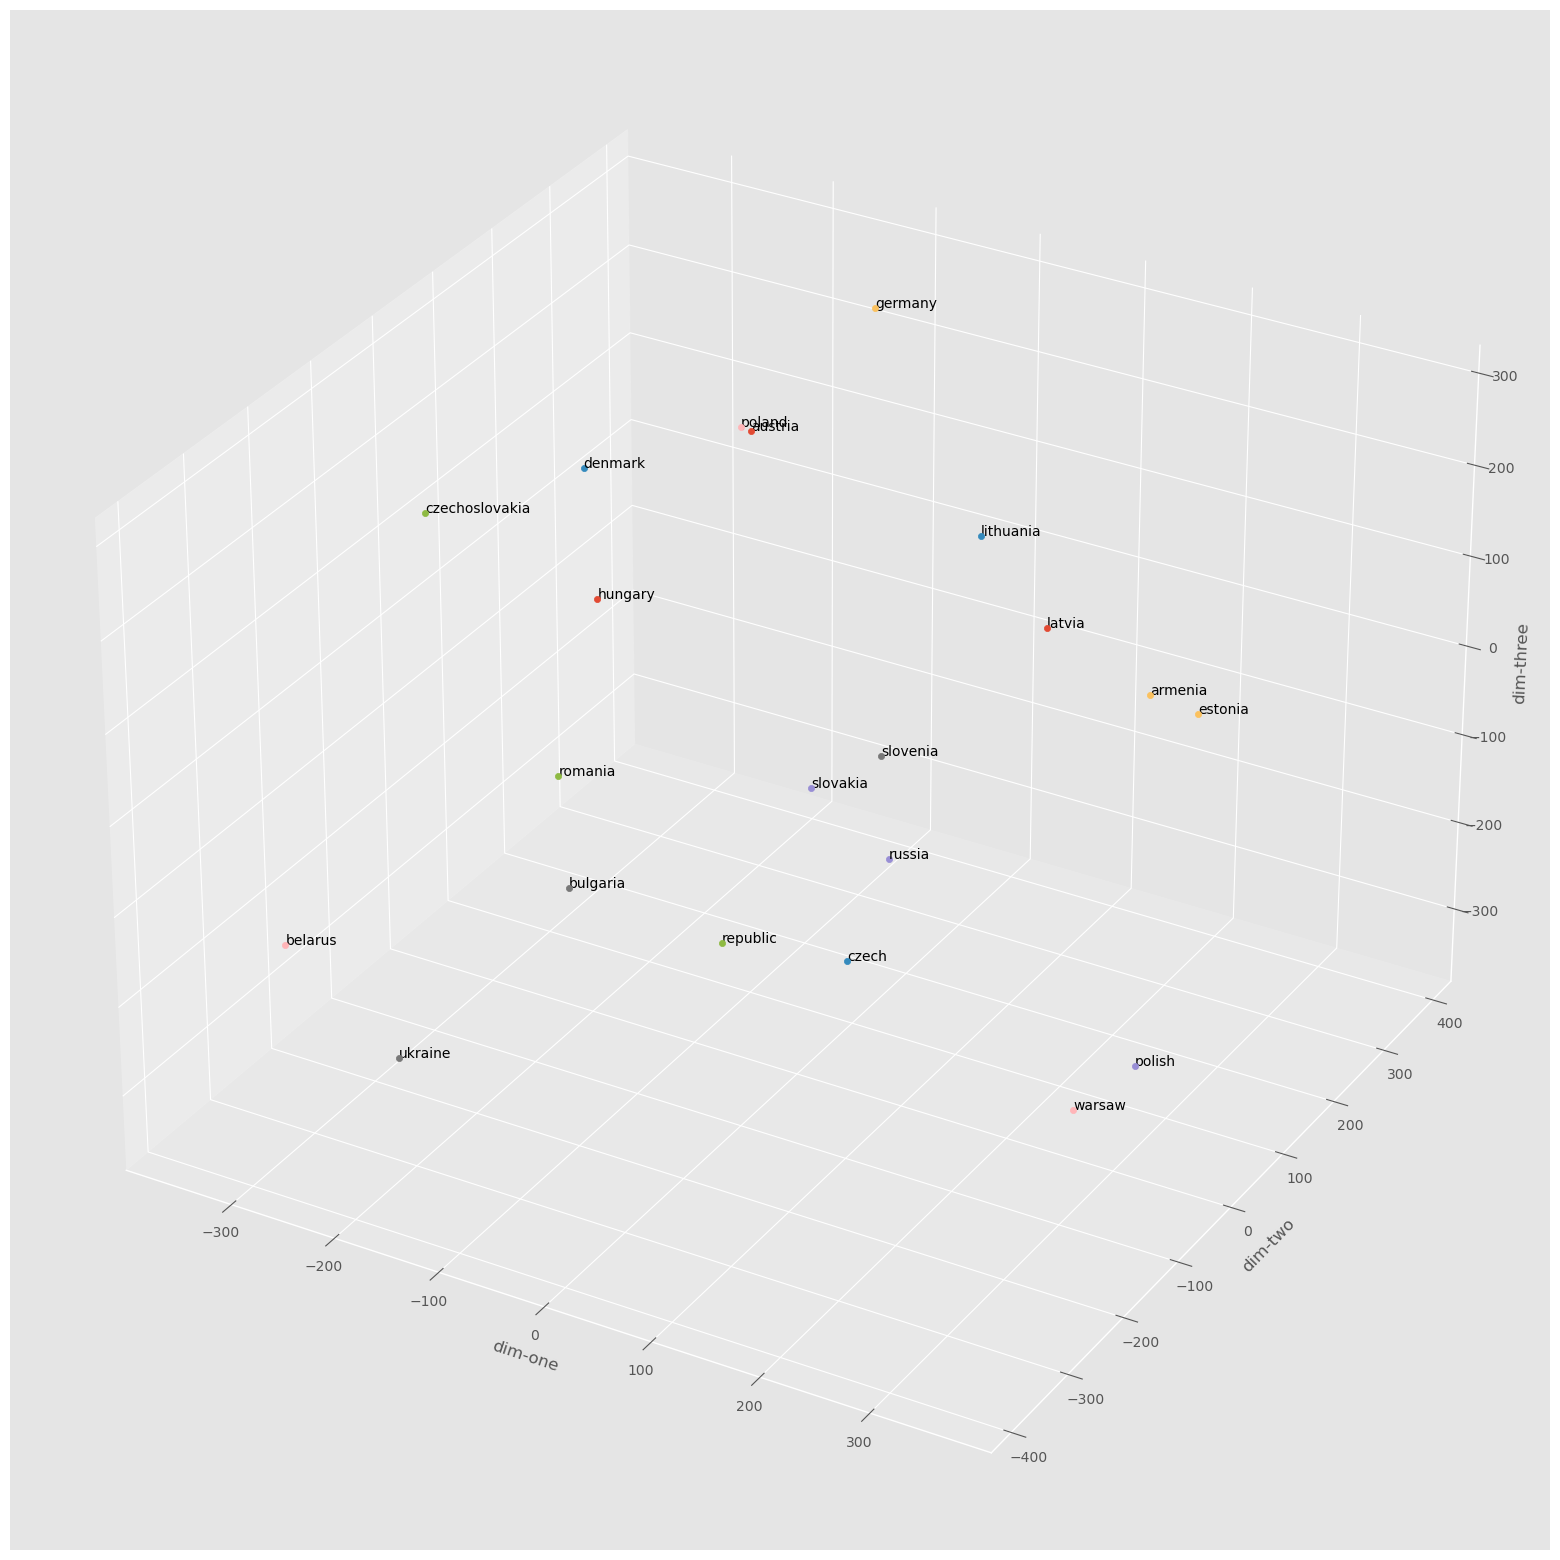

In [82]:
plot3D_with_labels(word='poland', k=20, model= self_attention_rnn)

--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>